In [1]:
import numpy as np
import math
import torch
import os
from __future__ import print_function, division
from matplotlib import pyplot as plt
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
from torch.utils import data
from scipy.io import loadmat, savemat
from enum import Enum

from grassdata import GRASSDataset, Tree

In [2]:
from dataset import SCORESTest
import draw3dOBB
import testVQContext
import testVQContextGen
import torch.utils.data
import math

## Some function definitions for box decoding

This one I modified from the GRASS code.

In [3]:
def tryPlot():
    cmap = plt.get_cmap('jet_r')
    fig = plt.figure()
    ax = Axes3D(fig)
    draw(ax, [-0.0152730000000000,-0.113074400000000,0.00867852000000000,0.766616000000000,0.483920000000000,0.0964542000000000,
               8.65505000000000e-06,-0.000113369000000000,0.999997000000000,0.989706000000000,0.143116000000000,7.65900000000000e-06], cmap(float(1)/7))
    draw(ax, [-0.310188000000000,0.188456800000000,0.00978854000000000,0.596362000000000,0.577190000000000,0.141414800000000,
               -0.331254000000000,0.943525000000000,0.00456327000000000,-0.00484978000000000,-0.00653891000000000,0.999967000000000], cmap(float(2)/7))
    draw(ax, [-0.290236000000000,-0.334664000000000,-0.328648000000000,0.322898000000000,0.0585966000000000,0.0347996000000000,
               -0.330345000000000,-0.942455000000000,0.0514932000000000,0.0432524000000000,0.0393726000000000,0.998095000000000], cmap(float(3)/7))
    draw(ax, [-0.289462000000000,-0.334842000000000,0.361558000000000,0.322992000000000,0.0593536000000000,0.0350418000000000,
               0.309240000000000,0.949730000000000,0.0485183000000000,-0.0511885000000000,-0.0343219000000000,0.998099000000000], cmap(float(4)/7))
    draw(ax, [0.281430000000000,-0.306584000000000,0.382928000000000,0.392156000000000,0.0409424000000000,0.0348472000000000,
               0.322342000000000,-0.942987000000000,0.0828920000000000,-0.0248683000000000,0.0791002000000000,0.996556000000000], cmap(float(5)/7))
    draw(ax, [0.281024000000000,-0.306678000000000,-0.366110000000000,0.392456000000000,0.0409366000000000,0.0348446000000000,
               -0.322608000000000,0.942964000000000,0.0821142000000000,0.0256742000000000,-0.0780031000000000,0.996622000000000], cmap(float(6)/7))
    draw(ax, [0.121108800000000,-0.0146729400000000,0.00279166000000000,0.681576000000000,0.601756000000000,0.0959706000000000,
               -0.986967000000000,-0.160173000000000,0.0155341000000000,0.0146809000000000,0.00650174000000000,0.999801000000000], cmap(float(7)/7))
    plt.show()

def draw(ax, p, color):
    tmpPoint = p

    center = tmpPoint[0: 3]
    lengths = tmpPoint[3: 6]
    dir_1 = tmpPoint[6: 9]
    dir_2 = tmpPoint[9: ]

    dir_1 = dir_1/LA.norm(dir_1)
    dir_2 = dir_2/LA.norm(dir_2)
    dir_3 = np.cross(dir_1, dir_2)
    dir_3 = dir_3/LA.norm(dir_3)
    cornerpoints = np.zeros([8, 3])
    

    d1 = 0.5*lengths[0]*dir_1
    d2 = 0.5*lengths[1]*dir_2
    d3 = 0.5*lengths[2]*dir_3

    cornerpoints[0][:] = center - d1 - d2 - d3
    cornerpoints[1][:] = center - d1 + d2 - d3
    cornerpoints[2][:] = center + d1 - d2 - d3
    cornerpoints[3][:] = center + d1 + d2 - d3
    cornerpoints[4][:] = center - d1 - d2 + d3
    cornerpoints[5][:] = center - d1 + d2 + d3
    cornerpoints[6][:] = center + d1 - d2 + d3
    cornerpoints[7][:] = center + d1 + d2 + d3

    ax.plot([cornerpoints[0][0], cornerpoints[1][0]], [cornerpoints[0][1], cornerpoints[1][1]],
            [cornerpoints[0][2], cornerpoints[1][2]], c=color)
    ax.plot([cornerpoints[0][0], cornerpoints[2][0]], [cornerpoints[0][1], cornerpoints[2][1]],
            [cornerpoints[0][2], cornerpoints[2][2]], c=color)
    ax.plot([cornerpoints[1][0], cornerpoints[3][0]], [cornerpoints[1][1], cornerpoints[3][1]],
            [cornerpoints[1][2], cornerpoints[3][2]], c=color)
    ax.plot([cornerpoints[2][0], cornerpoints[3][0]], [cornerpoints[2][1], cornerpoints[3][1]],
            [cornerpoints[2][2], cornerpoints[3][2]], c=color)
    ax.plot([cornerpoints[4][0], cornerpoints[5][0]], [cornerpoints[4][1], cornerpoints[5][1]],
            [cornerpoints[4][2], cornerpoints[5][2]], c=color)
    ax.plot([cornerpoints[4][0], cornerpoints[6][0]], [cornerpoints[4][1], cornerpoints[6][1]],
            [cornerpoints[4][2], cornerpoints[6][2]], c=color)
    ax.plot([cornerpoints[5][0], cornerpoints[7][0]], [cornerpoints[5][1], cornerpoints[7][1]],
            [cornerpoints[5][2], cornerpoints[7][2]], c=color)
    ax.plot([cornerpoints[6][0], cornerpoints[7][0]], [cornerpoints[6][1], cornerpoints[7][1]],
            [cornerpoints[6][2], cornerpoints[7][2]], c=color)
    ax.plot([cornerpoints[0][0], cornerpoints[4][0]], [cornerpoints[0][1], cornerpoints[4][1]],
            [cornerpoints[0][2], cornerpoints[4][2]], c=color)
    ax.plot([cornerpoints[1][0], cornerpoints[5][0]], [cornerpoints[1][1], cornerpoints[5][1]],
            [cornerpoints[1][2], cornerpoints[5][2]], c=color)
    ax.plot([cornerpoints[2][0], cornerpoints[6][0]], [cornerpoints[2][1], cornerpoints[6][1]],
            [cornerpoints[2][2], cornerpoints[6][2]], c=color)
    ax.plot([cornerpoints[3][0], cornerpoints[7][0]], [cornerpoints[3][1], cornerpoints[7][1]],
            [cornerpoints[3][2], cornerpoints[7][2]], c=color)

def showGenshapes(genshapes):
    for i in range(len(genshapes)):
        recover_boxes = genshapes[i]

        fig = plt.figure(i)
        cmap = plt.get_cmap('jet_r')
        ax = Axes3D(fig)
        ax.set_xlim(-0.7, 0.7)
        ax.set_ylim(-0.7, 0.7)
        ax.set_zlim(-0.7, 0.7)

        for jj in range(len(recover_boxes)):
            p = recover_boxes[jj][:]
            draw(ax, p, cmap(float(jj)/len(recover_boxes)))

        plt.show()

def showGenshape(genshape):
    recover_boxes = genshape

    fig = plt.figure(0)
    cmap = plt.get_cmap('jet_r')
    ax = Axes3D(fig, auto_add_to_figure=False)
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_zlim(-0.7, 0.7)
    fig.add_axes(ax)

    for jj in range(len(recover_boxes)):
        p = recover_boxes[jj][:].squeeze(0).numpy()
        draw(ax, p, cmap(float(jj)/len(recover_boxes)))

    plt.show()

In [4]:
def decode_boxes(root):
    """
    Decode a root code into a tree structure of boxes
    """
    syms = [torch.ones(8).mul(10)]
    stack = [root]
    boxes = []
    labels = []
    syms_out = []
    while len(stack) > 0:
        node = stack.pop()
        node_type = torch.LongTensor([node.node_type.value]).item()
        if node_type == 1:  # ADJ
            # left, right = model.adjDecoder(f)
            stack.append(node.left)
            stack.append(node.right)
            s = syms.pop()
            syms.append(s)
            syms.append(s)
        if node_type == 2:  # SYM
            # left, s = model.symDecoder(f)
            # s = s.squeeze(0)
            stack.append(node.left)
            syms.pop()
            syms.append(node.sym.squeeze(0))
            #print(node.sym.squeeze(0))
        if node_type == 0:  # BOX
            reBox = node.box
            s = syms.pop()
            boxes.append(reBox)
            syms_out.append(s)
            #print(node.label.item())
            labels.append(node.label)
    return boxes, syms_out, labels

This is from GRASS

In [5]:
def vrrotvec2mat(rotvector):
    s = math.sin(rotvector[3])
    c = math.cos(rotvector[3])
    t = 1 - c
    x = rotvector[0]
    y = rotvector[1]
    z = rotvector[2]
    #m = torch.FloatTensor([[t*x*x+c, t*x*y-s*z, t*x*z+s*y], [t*x*y+s*z, t*y*y+c, t*y*z-s*x], [t*x*z-s*y, t*y*z+s*x, t*z*z+c]]).cuda()
    m = torch.FloatTensor([[t*x*x+c, t*x*y-s*z, t*x*z+s*y], [t*x*y+s*z, t*y*y+c, t*y*z-s*x], [t*x*z-s*y, t*y*z+s*x, t*z*z+c]])
    return m


def decode_structure(root):
    """
    Decode a root code into a tree structure of boxes
    """
    # decode = model.sampleDecoder(root_code)
    syms = [torch.ones(8).mul(10)]
    stack = [root]
    boxes = []
    while len(stack) > 0:
        node = stack.pop()
        # label_prob = model.nodeClassifier(f)
        # _, label = torch.max(label_prob, 1)
        #label = node.label.item()
        node_type = torch.LongTensor([node.node_type.value]).item()
        if node_type == 1:  # ADJ
            # left, right = model.adjDecoder(f)
            stack.append(node.left)
            stack.append(node.right)
            s = syms.pop()
            syms.append(s)
            syms.append(s)
        if node_type == 2:  # SYM
            # left, s = model.symDecoder(f)
            # s = s.squeeze(0)
            stack.append(node.left)
            syms.pop()
            syms.append(node.sym.squeeze(0))
        if node_type == 0:  # BOX
            reBox = node.box
            reBoxes = [reBox]
            s = syms.pop()
            l1 = abs(s[0] + 1)
            l2 = abs(s[0])
            l3 = abs(s[0] - 1)
            if l1 < 0.15:
                sList = torch.split(s, 1, 0)
                bList = torch.split(reBox.data.squeeze(0), 1, 0)
                f1 = torch.cat([sList[1], sList[2], sList[3]])
                f1 = f1/torch.norm(f1)
                f2 = torch.cat([sList[4], sList[5], sList[6]])
                folds = round(1/s[7].item())
                for i in range(folds-1):
                    rotvector = torch.cat([f1, sList[7].mul(2*3.1415).mul(i+1)])
                    rotm = vrrotvec2mat(rotvector)
                    center = torch.cat([bList[0], bList[1], bList[2]])
                    dir0 = torch.cat([bList[3], bList[4], bList[5]])
                    dir1 = torch.cat([bList[6], bList[7], bList[8]])
                    dir2 = torch.cat([bList[9], bList[10], bList[11]])
                    newcenter = rotm.matmul(center.add(-f2)).add(f2)
                    newdir1 = rotm.matmul(dir1)
                    newdir2 = rotm.matmul(dir2)
                    newbox = torch.cat([newcenter, dir0, newdir1, newdir2])
                    reBoxes.append(newbox)
            if l3 < 0.15:
                sList = torch.split(s, 1, 0)
                bList = torch.split(reBox.data.squeeze(0), 1, 0)
                trans = torch.cat([sList[1], sList[2], sList[3]])
                trans_end = torch.cat([sList[4], sList[5], sList[6]])
                center = torch.cat([bList[0], bList[1], bList[2]])
                trans_length = math.sqrt(torch.sum(trans**2))
                trans_total = math.sqrt(torch.sum(trans_end.add(-center)**2))
                folds = round(trans_total/trans_length)
                for i in range(folds):
                    center = torch.cat([bList[0], bList[1], bList[2]])
                    dir0 = torch.cat([bList[3], bList[4], bList[5]])
                    dir1 = torch.cat([bList[6], bList[7], bList[8]])
                    dir2 = torch.cat([bList[9], bList[10], bList[11]])
                    newcenter = center.add(trans.mul(i+1))
                    newbox = torch.cat([newcenter, dir0, dir1, dir2])
                    reBoxes.append(newbox)
            if l2 < 0.15:
                sList = torch.split(s, 1, 0)
                bList = torch.split(reBox.data.squeeze(0), 1, 0)
                ref_normal = torch.cat([sList[1], sList[2], sList[3]])
                ref_normal = ref_normal/torch.norm(ref_normal)
                ref_point = torch.cat([sList[4], sList[5], sList[6]])
                center = torch.cat([bList[0], bList[1], bList[2]])
                dir0 = torch.cat([bList[3], bList[4], bList[5]])
                dir1 = torch.cat([bList[6], bList[7], bList[8]])
                dir2 = torch.cat([bList[9], bList[10], bList[11]])
                if ref_normal.matmul(ref_point.add(-center)) < 0:
                    ref_normal = -ref_normal
                newcenter = ref_normal.mul(2*abs(torch.sum(ref_point.add(-center).mul(ref_normal)))).add(center)
                if ref_normal.matmul(dir1) < 0:
                    ref_normal = -ref_normal
                dir1 = dir1.add(ref_normal.mul(-2*ref_normal.matmul(dir1)))
                if ref_normal.matmul(dir2) < 0:
                    ref_normal = -ref_normal
                dir2 = dir2.add(ref_normal.mul(-2*ref_normal.matmul(dir2)))
                newbox = torch.cat([newcenter, dir0, dir1, dir2])
                reBoxes.append(newbox)

            boxes.extend(reBoxes)
    return boxes

In [6]:
def decode_structure_with_labels(root):
    """
    Decode a root code into a tree structure of boxes
    """
    # decode = model.sampleDecoder(root_code)
    syms = [torch.ones(8).mul(10)]
    stack = [root]
    boxes = []
    labels = []
    while len(stack) > 0:
        node = stack.pop()
        # label_prob = model.nodeClassifier(f)
        # _, label = torch.max(label_prob, 1)
        #label = node.label.item()
        node_type = torch.LongTensor([node.node_type.value]).item()
        if node_type == 1:  # ADJ
            # left, right = model.adjDecoder(f)
            stack.append(node.left)
            stack.append(node.right)
            s = syms.pop()
            syms.append(s)
            syms.append(s)
        if node_type == 2:  # SYM
            # left, s = model.symDecoder(f)
            # s = s.squeeze(0)
            stack.append(node.left)
            syms.pop()
            syms.append(node.sym.squeeze(0))
        if node_type == 0:  # BOX
            reBox = node.box
            reBoxes = [reBox]
            label = node.label.item()
            s = syms.pop()
            l1 = abs(s[0] + 1)
            l2 = abs(s[0])
            l3 = abs(s[0] - 1)
            if l1 < 0.15:
                sList = torch.split(s, 1, 0)
                bList = torch.split(reBox.data.squeeze(0), 1, 0)
                f1 = torch.cat([sList[1], sList[2], sList[3]])
                f1 = f1/torch.norm(f1)
                f2 = torch.cat([sList[4], sList[5], sList[6]])
                folds = round(1/s[7].item())
                for i in range(folds-1):
                    rotvector = torch.cat([f1, sList[7].mul(2*3.1415).mul(i+1)])
                    rotm = vrrotvec2mat(rotvector)
                    center = torch.cat([bList[0], bList[1], bList[2]])
                    dir0 = torch.cat([bList[3], bList[4], bList[5]])
                    dir1 = torch.cat([bList[6], bList[7], bList[8]])
                    dir2 = torch.cat([bList[9], bList[10], bList[11]])
                    newcenter = rotm.matmul(center.add(-f2)).add(f2)
                    newdir1 = rotm.matmul(dir1)
                    newdir2 = rotm.matmul(dir2)
                    newbox = torch.cat([newcenter, dir0, newdir1, newdir2])
                    reBoxes.append(newbox)
            if l3 < 0.15:
                sList = torch.split(s, 1, 0)
                bList = torch.split(reBox.data.squeeze(0), 1, 0)
                trans = torch.cat([sList[1], sList[2], sList[3]])
                trans_end = torch.cat([sList[4], sList[5], sList[6]])
                center = torch.cat([bList[0], bList[1], bList[2]])
                trans_length = math.sqrt(torch.sum(trans**2))
                trans_total = math.sqrt(torch.sum(trans_end.add(-center)**2))
                folds = round(trans_total/trans_length)
                for i in range(folds):
                    center = torch.cat([bList[0], bList[1], bList[2]])
                    dir0 = torch.cat([bList[3], bList[4], bList[5]])
                    dir1 = torch.cat([bList[6], bList[7], bList[8]])
                    dir2 = torch.cat([bList[9], bList[10], bList[11]])
                    newcenter = center.add(trans.mul(i+1))
                    newbox = torch.cat([newcenter, dir0, dir1, dir2])
                    reBoxes.append(newbox)
            if l2 < 0.15:
                sList = torch.split(s, 1, 0)
                bList = torch.split(reBox.data.squeeze(0), 1, 0)
                ref_normal = torch.cat([sList[1], sList[2], sList[3]])
                ref_normal = ref_normal/torch.norm(ref_normal)
                ref_point = torch.cat([sList[4], sList[5], sList[6]])
                center = torch.cat([bList[0], bList[1], bList[2]])
                dir0 = torch.cat([bList[3], bList[4], bList[5]])
                dir1 = torch.cat([bList[6], bList[7], bList[8]])
                dir2 = torch.cat([bList[9], bList[10], bList[11]])
                if ref_normal.matmul(ref_point.add(-center)) < 0:
                    ref_normal = -ref_normal
                newcenter = ref_normal.mul(2*abs(torch.sum(ref_point.add(-center).mul(ref_normal)))).add(center)
                if ref_normal.matmul(dir1) < 0:
                    ref_normal = -ref_normal
                dir1 = dir1.add(ref_normal.mul(-2*ref_normal.matmul(dir1)))
                if ref_normal.matmul(dir2) < 0:
                    ref_normal = -ref_normal
                dir2 = dir2.add(ref_normal.mul(-2*ref_normal.matmul(dir2)))
                newbox = torch.cat([newcenter, dir0, dir1, dir2])
                reBoxes.append(newbox)

            boxes.extend(reBoxes)
            labels.extend(len(reBoxes) * [label])
    return boxes, labels

Generate MAT files for SCORES input

In [7]:
def saveMats(boxes, syms, directory, suffix):
    # adjGen
    mat = torch.ones([4,1])*(-1)
    savemat(directory + '/adjGen.mat', {'adjGen': mat.numpy()})
    
    # boxes
    mat = torch.zeros([12,30])
    for k in range(len(boxes)):
        mat[:,k] = boxes[k]
    key = 'boxes' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})
    
    # syms
    mat = torch.ones([8,30])*(-1)
    for k in range(len(syms)):
        mat[:,k] = syms[k]
        if abs(mat[0,k]-1) < 0.16:
            mat[0,k] = mat[0,k] - 1
        elif abs(mat[0,k]) < 0.16:
            mat[0,k] = mat[0,k] + 1
    key = 'syms' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})
    
    # idx
    mat = torch.zeros([30,1])
    for k in range(len(boxes)):
        mat[k] = np.random.randint(20)
    key = 'idx' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})
    
    # adj
    mat = torch.zeros([30,30])
    if len(boxes) == 3:
        mat[0,2] = 1
        mat[2,0] = 1
        mat[1,2] = 1
        mat[2,1] = 1
    key = 'adj' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})

In [8]:
# for experiments where symmetry was ignored
def saveMatsNoSym(boxes, directory, suffix):
    # adjGen
    mat = torch.ones([4,1])*(-1)
    savemat(directory + '/adjGen.mat', {'adjGen': mat.numpy()})
    
    # boxes
    mat = torch.zeros([12,30])
    for k in range(len(boxes)):
        mat[:,k] = boxes[k]
    key = 'boxes' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})
    
    # syms
    mat = torch.ones([8,30])*(-1)
    for k in range(len(boxes)):
        mat[:,k] = 10
    key = 'syms' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})
    
    # idx
    mat = torch.zeros([30,1])
    for k in range(len(boxes)):
        mat[k] = np.random.randint(20)
    key = 'idx' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})
    
    # adj
    mat = torch.zeros([30,30])
    if len(boxes) == 3:
        mat[0,2] = 1
        mat[2,0] = 1
        mat[1,2] = 1
        mat[2,1] = 1
    key = 'adj' + suffix
    savemat(directory + '/' + key + '.mat', {key: mat.numpy()})

## Take a chair from our dataset and format it for use with SCORES
It is assumed that the database path is ..\data\chair\. Change that for your own directory structure.

In [9]:
# This function rearranges the boxes so that the ones with nontrivial symmetry parameters come first
# I've noticed this pattern in the SCORES input so just trying to be consistent with it
def reshuffle(boxes, syms, labels):
    new_boxes = []
    new_syms = []
    new_labels = []
    for box, sym, label in zip(boxes, syms, labels):
        if sym[0] == 10.:
            new_boxes.append(box)
            new_syms.append(sym)
            new_labels.append(label)
        else:
            new_boxes = [box] + new_boxes
            new_syms = [sym] + new_syms
            new_labels = [label] + new_labels
    return new_boxes, new_syms, new_labels

In [10]:
# These are two versions of rotating boxes and symmetries, the old one confused the SCORES NN
# The new one is better but needs a tweak for slanted boxes

# helper function to find which direction best fits to x, y or z
def bestDir(dirs, lens, comp):
    largestComp = 0
    bestDirection = dirs[0]
    bestLen = lens[0]
    for k in range(len(dirs)):
        direction = dirs[k]
        if direction[comp] > largestComp:
            bestDirection = direction
            largestComp = direction[comp]
            bestLen = lens[k]
        elif -direction[comp] > largestComp:
            bestDirection = -direction
            largestComp = -direction[comp]
            bestLen = lens[k]
    return bestDirection, bestLen

# newest version of box rotation
def rotate_boxes_smart(boxes, syms):
    new_boxes = torch.zeros(boxes.shape)
    
    for k in range(boxes.shape[0]):
        # rotate center vector
        new_boxes[k,0] = boxes[k,2]
        new_boxes[k,1] = boxes[k,1]
        new_boxes[k,2] = -boxes[k,0]
        
        # rotate principal directions
        new_boxes[k,6] = boxes[k,8]
        new_boxes[k,7] = boxes[k,7]
        new_boxes[k,8] = -boxes[k,6]
        
        new_boxes[k,9] = boxes[k,11]
        new_boxes[k,10] = boxes[k,10]
        new_boxes[k,11] = -boxes[k,9]
        
        # re-compute principal directions
        dir_1 = new_boxes[k,6:9]
        dir_2 = new_boxes[k,9:]
        dir_1 = dir_1/LA.norm(dir_1)
        dir_2 = dir_2/LA.norm(dir_2)
        dir_3 = np.cross(dir_1, dir_2)
        dir_3 = dir_3/LA.norm(dir_3)
        
        # realign axes
        x_dir, x_len = bestDir([dir_1, dir_2, dir_3], boxes[k,3:6], 0)
        y_dir, y_len = bestDir([dir_1, dir_2, dir_3], boxes[k,3:6], 1)
        z_dir, z_len = bestDir([dir_1, dir_2, dir_3], boxes[k,3:6], 2)
        
        new_boxes[k,3] = y_len
        new_boxes[k,4] = z_len
        new_boxes[k,5] = x_len

        new_boxes[k,6:9] = torch.FloatTensor(y_dir)
        new_boxes[k,9:12] = torch.FloatTensor(z_dir)

    # rotate syms
    new_syms = torch.zeros(syms.shape)
    for k in range(syms.shape[0]):
        new_syms[k,0] = syms[k,0]

        new_syms[k,1] = syms[k,3]
        new_syms[k,2] = syms[k,2]
        new_syms[k,3] = -syms[k,1]

        new_syms[k,4] = syms[k,6]
        new_syms[k,5] = syms[k,5]
        new_syms[k,6] = -syms[k,4]

        new_syms[k,7] = syms[k,7]
    return new_boxes, new_syms

def rotate_boxes_old(boxes, syms):
    new_boxes = torch.zeros(boxes.shape)
    for k in range(boxes.shape[0]):
        new_boxes[k,0] = boxes[k,2]
        new_boxes[k,1] = boxes[k,1]
        new_boxes[k,2] = -boxes[k,0]

        new_boxes[k,3] = boxes[k,3]
        new_boxes[k,4] = boxes[k,4]
        new_boxes[k,5] = boxes[k,5]

        new_boxes[k,6] = boxes[k,8]
        new_boxes[k,7] = boxes[k,7]
        new_boxes[k,8] = -boxes[k,6]

        new_boxes[k,9] = boxes[k,11]
        new_boxes[k,10] = boxes[k,10]
        new_boxes[k,11] = -boxes[k,9]

    # rotate syms
    new_syms = torch.zeros(syms.shape)
    for k in range(syms.shape[0]):
        new_syms[k,0] = syms[k,0]

        new_syms[k,1] = syms[k,3]
        new_syms[k,2] = syms[k,2]
        new_syms[k,3] = -syms[k,1]

        new_syms[k,4] = syms[k,6]
        new_syms[k,5] = syms[k,5]
        new_syms[k,6] = -syms[k,4]

        new_syms[k,7] = syms[k,7]
    return new_boxes, new_syms

Chair ID 1: 1127
Chair ID 2: 39700
Old Boxes 1:


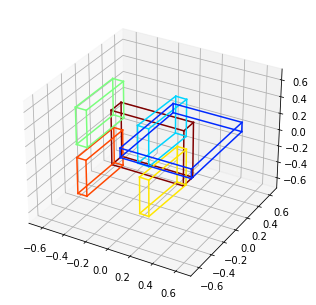

Old Boxes 2:


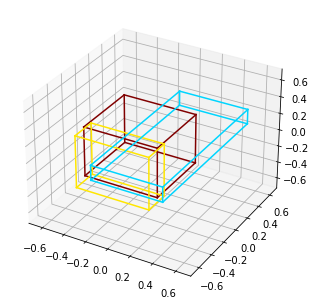

All Boxes 1:


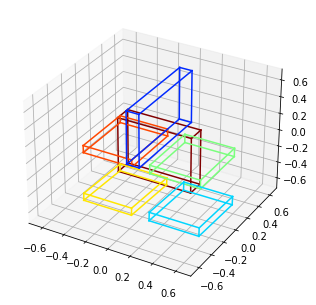

All Boxes 2:


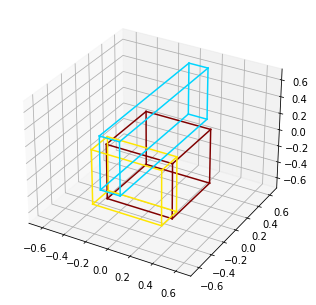

Boxes A:


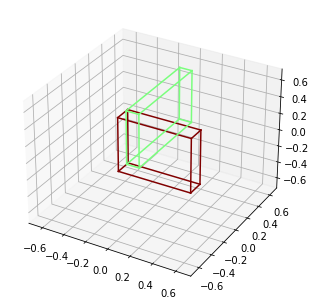

[tensor(1, dtype=torch.int32), tensor(2, dtype=torch.int32), tensor(0, dtype=torch.int32)]
Boxes B:


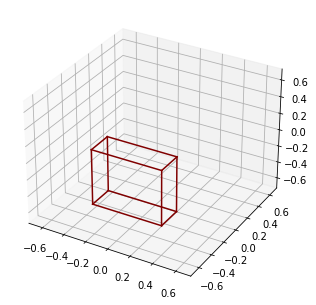

In [13]:
# Select the chair number that we want for first chair
k = 2

# load data from database
dir = '..\\data\\chair'
mat = loadmat('..\\data\\chair\\part mesh indices\\%s.mat' % (k,))
print('Chair ID 1:', mat['shapename'][0])
boxes1 = torch.from_numpy(loadmat(os.path.join(dir, 'boxes', '%d.mat' % (k,)))['box']).t().float()
ops1 = torch.from_numpy(loadmat(os.path.join(dir, 'ops', '%d.mat' % (k,)))['op']).int()
syms1 = torch.from_numpy(loadmat(os.path.join(dir, 'syms', '%d.mat' % (k,)))['sym']).t().float()
labels1 = torch.from_numpy(loadmat(os.path.join(dir, 'labels', '%d.mat' % (k,)))['label']).int()
old_tree1 = Tree(boxes1, ops1, syms1, labels1)

# Select the chair number that we want for first chair
k = 3339

# load data from database
dir = '..\\data\\chair'
mat = loadmat('..\\data\\chair\\part mesh indices\\%s.mat' % (k,))
print('Chair ID 2:', mat['shapename'][0])
boxes2 = torch.from_numpy(loadmat(os.path.join(dir, 'boxes', '%d.mat' % (k,)))['box']).t().float()
ops2 = torch.from_numpy(loadmat(os.path.join(dir, 'ops', '%d.mat' % (k,)))['op']).int()
syms2 = torch.from_numpy(loadmat(os.path.join(dir, 'syms', '%d.mat' % (k,)))['sym']).t().float()
labels2 = torch.from_numpy(loadmat(os.path.join(dir, 'labels', '%d.mat' % (k,)))['label']).int()
old_tree2 = Tree(boxes2, ops2, syms2, labels2)

oldboxes1 = decode_structure(old_tree1.root)
print('Old Boxes 1:')
showGenshape(oldboxes1)
oldboxes2 = decode_structure(old_tree2.root)
print('Old Boxes 2:')
showGenshape(oldboxes2)

# rotate boxes (SCORES uses different rotation)
new_boxes1, new_syms1 = rotate_boxes_smart(boxes1, syms1)
new_boxes2, new_syms2 = rotate_boxes_smart(boxes2, syms2)

# generate new tree
new_tree1 = Tree(new_boxes1, ops1, new_syms1, labels1)
allnewboxes = decode_structure(new_tree1.root)
print('All Boxes 1:')
showGenshape(allnewboxes)
boxes1, syms1, labels1 = decode_boxes(new_tree1.root)
#boxes1, labels1 = decode_structure_with_labels(new_tree1.root)

new_tree2 = Tree(new_boxes2, ops2, new_syms2, labels2)
allnewboxes = decode_structure(new_tree2.root)
print('All Boxes 2:')
showGenshape(allnewboxes)
boxes2, syms2, labels2 = decode_boxes(new_tree2.root)
#boxes2, labels2 = decode_structure_with_labels(new_tree2.root)

# select boxes with labels 0 and 1 from tree 1 (seat and back)
ids = [i for i in range(len(labels1)) if labels1[i] in [0,1]]
boxes_A = [boxes1[i] for i in ids]
syms_A = [syms1[i] for i in ids]
labels_A = [labels1[i] for i in ids]
boxes_A, syms_A, labels_A = reshuffle(boxes_A, syms_A, labels_A)
print('Boxes A:')
showGenshape(boxes_A)

# select boxes with labels 2 and 3 from tree 2
print(labels2)
ids = [i for i in range(len(labels2)) if labels2[i] in [2,3]]
boxes_B = [boxes2[i] for i in ids]
syms_B = [syms2[i] for i in ids]
labels_B = [labels2[i] for i in ids]
boxes_B, syms_B, labels_B = reshuffle(boxes_B, syms_B, labels_B)
print('Boxes B:')
showGenshape(boxes_B)

# save A and B data for use in SCORES
#saveMatsNoSym(boxes_A, 'test_one_shape', 'A')
#saveMatsNoSym(boxes_B, 'test_one_shape', 'B')
saveMats(boxes_A, syms_A, 'test_one_shape', 'A')
saveMats(boxes_B, syms_B, 'test_one_shape', 'B')

Input Boxes:


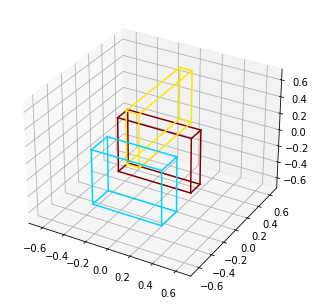

2.5337797637803305e-07
1.9455521282907284e-07
1.8015424529949087e-07
1.7630893012210436e-07
17 output boxes:


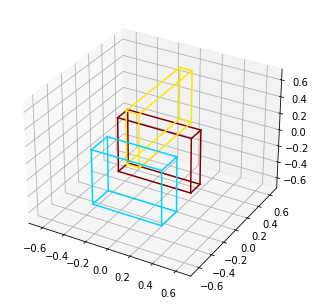

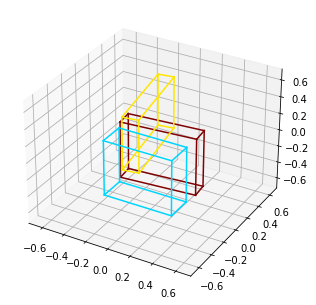

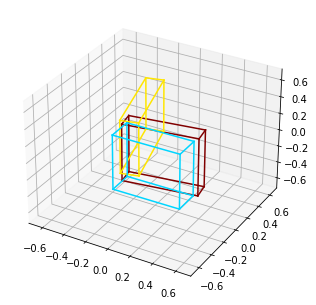

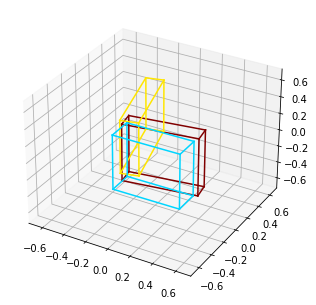

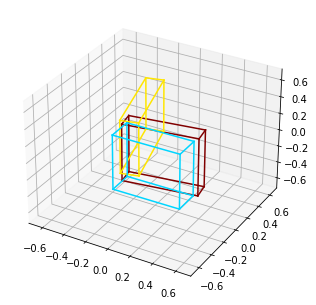

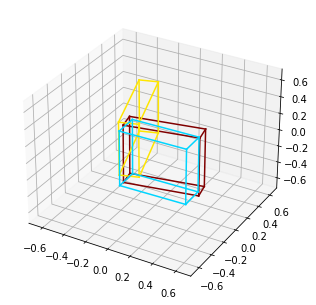

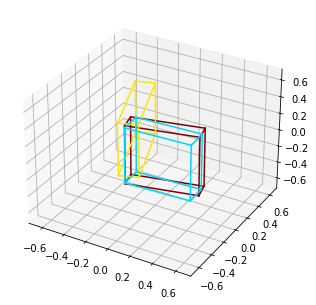

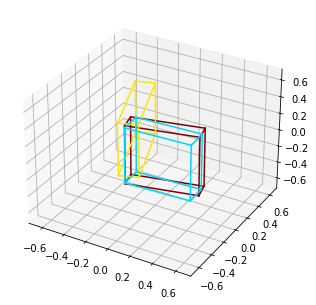

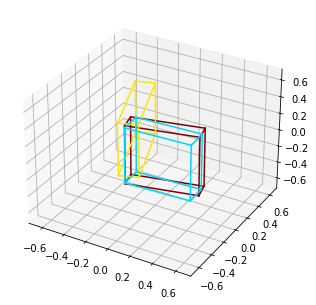

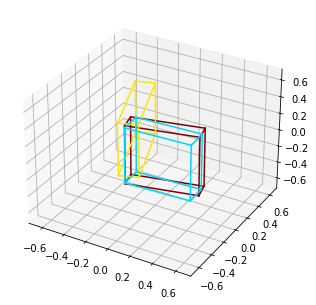

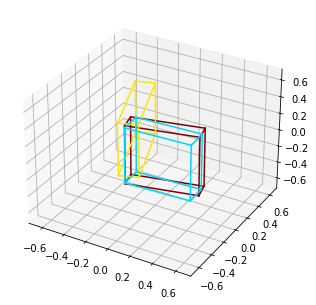

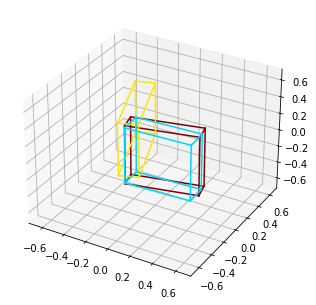

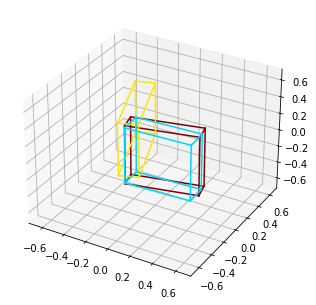

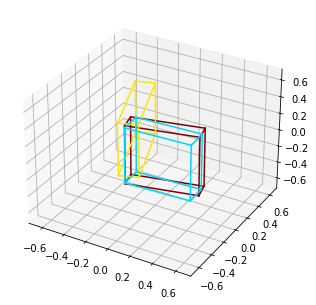

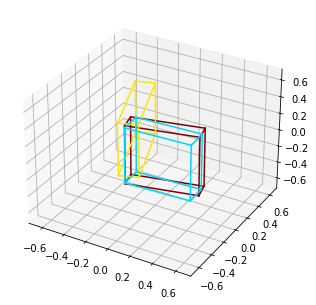

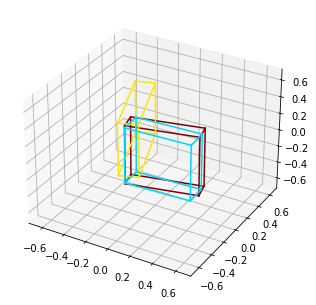

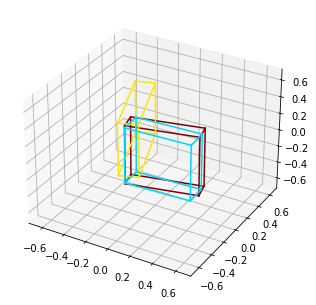

In [14]:
# Run scores on the new data
allTestData = SCORESTest('test_one_shape')
testFile = allTestData[0]
originalNodes = testFile.leves
boxes = testVQContext.render_node_to_boxes(originalNodes)
print('Input Boxes:')
draw3dOBB.showGenshape(torch.cat(boxes,0).numpy())

mergeNetFix = torch.load('MergeNet_chair_demo_fix.pkl', map_location=torch.device('cpu'))
mergeNetFix = mergeNetFix.cpu()

if len(boxes) < 4:
    allBoxes = testVQContext.iterateKMergeTest(mergeNetFix, testFile, sampleK=len(boxes))
else:
    allBoxes = testVQContext.iterateKMergeTest(mergeNetFix, testFile, sampleK=4)
    
print(len(allBoxes), 'output boxes:')
for boxes in allBoxes:
    draw3dOBB.showGenshape(torch.cat(boxes,0).numpy())

In [36]:
print(boxes)

[tensor([[ 5.9995e-02,  4.3823e-02, -7.5533e-03,  8.0068e-02,  6.1184e-01,
          5.6541e-01, -8.1708e-03,  9.9745e-01,  3.8717e-04, -3.3033e-03,
         -2.8505e-04,  9.9919e-01]]), tensor([[-0.2491,  0.1885, -0.0269,  0.6448,  0.6047,  0.1544, -0.2824,  0.9562,
         -0.0053,  0.0043,  0.0073,  0.9997]]), tensor([[-0.2071, -0.1594, -0.3121,  0.7170,  0.0287,  0.0500,  0.2159,  0.9704,
          0.0059,  0.0041, -0.0051,  0.9986]]), tensor([[-0.2089, -0.1588,  0.3129,  0.7170,  0.0287,  0.0500,  0.2159,  0.9704,
         -0.0067,  0.0100, -0.0072, -0.9985]]), tensor([[-0.0052, -0.4614, -0.3036,  0.0559,  0.0317,  0.8296,  0.0389,  0.9972,
          0.0539, -0.0054, -0.0528,  0.9972]]), tensor([[-0.0045, -0.4614,  0.3028,  0.0559,  0.0317,  0.8296,  0.0388,  0.9972,
         -0.0542, -0.0076, -0.0530, -0.9972]]), tensor([[ 2.2229e-01, -7.4327e-03, -2.4212e-01,  1.9159e-01,  2.0239e-02,
          3.3682e-02, -1.0959e-02,  9.9804e-01, -7.8961e-03, -8.9478e-04,
          3.2340e-03